In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary

In [3]:
PATH = Path("dataset") / "GTSRB" / "Training"
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [4]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = "cuda"#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0
    for images,_ in dataloader: # load a batch at a time
        n = images.size(0)
        total += 1
        mean  += images.mean(dim=[0,2,3])
        std   += images.std(dim=[0,2,3])
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor([0.3397, 0.3117, 0.3210]), tensor([0.2299, 0.2247, 0.2332]))

In [6]:
mean = torch.tensor([0.3397, 0.3117, 0.3210])
std = torch.tensor([0.2299, 0.2247, 0.2332])

def to_image(img): # convert to unormalized form for viewing
    _mean = mean.view(3,1,1)
    _std = std.view(3,1,1)
    return (img * _std + _mean).permute(1,2,0).numpy()

transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [7]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

Yield


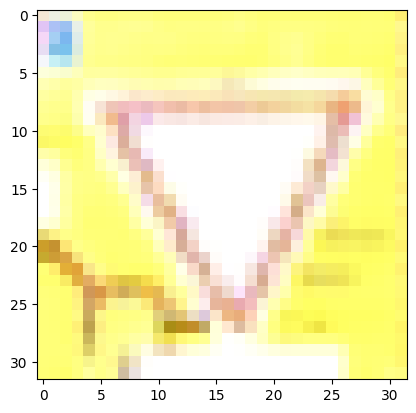

In [8]:
for img,label in train_loader:
    img = to_image(img[0])
    plt.imshow(img)
    print(LABELS[label[0]])
    break

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,3,_N,_N))
        self.activation = torch.nn.functional.relu
        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(3,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = torch.compile(Model()).to(device)
summary(model,(3,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 6, 28, 28]             456
         MaxPool2d-2           [256, 6, 14, 14]               0
            Conv2d-3          [256, 16, 10, 10]           2,416
         MaxPool2d-4            [256, 16, 5, 5]               0
            Linear-5                 [256, 128]          51,328
            Linear-6                  [256, 64]           8,256
            Linear-7                  [256, 43]           2,795
             Model-8                  [256, 43]               0
Total params: 65,251
Trainable params: 65,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 15.93
Params size (MB): 0.25
Estimated Total Size (MB): 19.18
----------------------------------------------------------------


In [10]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [ ]:

def train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader):.3f}")

In [12]:
train(model,loss,optimiser)

Epoch 1: Loss 2.609
Epoch 2: Loss 0.834
Epoch 3: Loss 0.455
Epoch 4: Loss 0.316
Epoch 5: Loss 0.238
Epoch 6: Loss 0.182
Epoch 7: Loss 0.143
Epoch 8: Loss 0.122
Epoch 9: Loss 0.103
Epoch 10: Loss 0.084
Epoch 11: Loss 0.070
Epoch 12: Loss 0.060
Epoch 13: Loss 0.057
Epoch 14: Loss 0.043
Epoch 15: Loss 0.035
Epoch 16: Loss 0.033
Epoch 17: Loss 0.029
Epoch 18: Loss 0.027
Epoch 19: Loss 0.027
Epoch 20: Loss 0.028
Epoch 21: Loss 0.021
Epoch 22: Loss 0.025
Epoch 23: Loss 0.016
Epoch 24: Loss 0.011
Epoch 25: Loss 0.014
Epoch 26: Loss 0.010
Epoch 27: Loss 0.009
Epoch 28: Loss 0.009
Epoch 29: Loss 0.019
Epoch 30: Loss 0.036


In [29]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.9816
Recall (macro): 0.9810
F1-score (macro): 0.9810
